In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.1 MB/s eta 0:00:00


# CARGA DE LIBRERIAS

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="darkgrid", palette="pastel")
sns.set(rc={'figure.figsize':(10,10)})
from scipy.stats import ttest_ind
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

# CARGA INFORMACIÓN

In [ ]:
import pandas as pd

# Reemplaza la ruta con la ubicación de tu archivo Stata (.dta)
file_path = "/content/drive/MyDrive/Proyecto Grado/HDMA/Version Final/LAR_18_19_Muestra.dta"

# Cargar el archivo Stata en un DataFrame
data = pd.read_stata(file_path)


In [ ]:
# Convertir valores de action_taken2 a minúsculas
data['action_taken2'] = data['action_taken2'].str.lower()

# Mapeo de los valores de action_taken2 a los valores correspondientes en action_taken3
mapping = {
    'aprobado': 'Otorgado',
    'negado': 'No Otorgado',
    'no finalizado': 'No Otorgado'
}

# Crear la nueva columna action_taken3 basada en los valores de action_taken2
data['action_taken3'] = data['action_taken2'].replace(mapping)

In [ ]:
# Convertir valores a cadenas y guardar los originales en nuevas columnas
columns_to_check = ['protegido_edad', 'no_protegido_edad', 'protegido_mujer', 'no_protegido_hombre', 'protegido_raza', 'no_protegido_raza']

for column in columns_to_check:
    # Crear una nueva columna con el nombre original + '_antes_conversion'
    data[column + '_antes_conversion'] = data[column]
    # Convertir los valores a numéricos
    data[column] = pd.to_numeric(data[column], errors='coerce')

import numpy as np

# Crear la nueva columna 'poblacion_protegida' basada en las condiciones
data['poblacion_protegida'] = np.where(
    (data['protegido_edad'] == 1) |
    (data['protegido_mujer'] == 1) |
    (data['protegido_raza'] == 1),
    1,  # Si alguna de las condiciones se cumple, asigna 1
    np.where(
        (data['no_protegido_edad'] == 1) |
        (data['no_protegido_hombre'] == 1) |
        (data['no_protegido_raza'] == 1),
        0,  # Si alguna de las condiciones se cumple, asigna 0
        np.nan  # Si ninguna de las condiciones se cumple, asigna NaN por defecto
    )
)

# Crear una nueva columna 'poblacion_protegida_nueva' basada en las condiciones
data['poblacion_protegida_nueva'] = np.where(
    (data['protegido_edad'] == 1) |
    (data['protegido_mujer'] == 1) |
    (data['protegido_raza'] == 1),
    1,  # Si alguna de las condiciones se cumple, asigna 1
    np.where(
        (data['no_protegido_edad'] == 1) |
        (data['no_protegido_hombre'] == 1) |
        (data['no_protegido_raza'] == 1),
        0,  # Si alguna de las condiciones se cumple, asigna 0
        np.nan  # Si ninguna de las condiciones se cumple, asigna NaN por defecto
    )
)


In [ ]:
#{-2.0: 'Protegido', 3.000004: 'No Protegido' Se transforma a 1}
print(data['poblacion_protegida'].value_counts())

1.0    531022
0.0    468978
Name: poblacion_protegida, dtype: int64


In [ ]:
#{-2.0: 'Protegido', 3.000004: 'No Protegido' Se transforma a 1}
print(data['poblacion_protegida_nueva'].value_counts())

1.0    531022
0.0    468978
Name: poblacion_protegida_nueva, dtype: int64


In [ ]:
print("Valores únicos en protegido_edad:", data['protegido_edad'].unique())
print("Valores únicos en no_protegido_edad:", data['protegido_edad'].unique())
print("Valores únicos en protegido_mujer:", data['protegido_mujer'].unique())
print("Valores únicos en no_protegido_hombre:", data['protegido_mujer'].unique())
print("Valores únicos en protegido_raza:", data['protegido_raza'].unique())
print("Valores únicos en no_protegido_raza:", data['protegido_raza'].unique())


Valores únicos en protegido_edad: [0 1]
Valores únicos en no_protegido_edad: [0 1]
Valores únicos en protegido_mujer: [1 0]
Valores únicos en no_protegido_hombre: [1 0]
Valores únicos en protegido_raza: [1 0]
Valores únicos en no_protegido_raza: [1 0]


In [ ]:
# Información sobre tipos de datos y valores nulos
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 70 columns):
 #   Column                                Non-Null Count    Dtype   
---  ------                                --------------    -----   
 0   activity_year                         1000000 non-null  int16   
 1   lei                                   1000000 non-null  object  
 2   state_code                            1000000 non-null  object  
 3   county_code                           1000000 non-null  object  
 4   action_taken                          1000000 non-null  category
 5   purchaser_type                        1000000 non-null  category
 6   preapproval                           1000000 non-null  int8    
 7   loan_type                             1000000 non-null  category
 8   loan_purpose                          1000000 non-null  category
 9   lien_status                           1000000 non-null  int8    
 10  reverse_mortgage                      97397

# MODELAMIENTO Y SELECCION DE MEJOR MODELO

Se abordan los siguientes pasos:

Preparar el conjunto de datos
Dividir en el entrenamiento y la prueba
Transformar/Codificar las etiquetas de las variables
PExplorar diferents modelos de clasificacion
Compara el desempeño de todos los modelos.
Seleccionar un  modelo ganador y ajuste los hiperparámetros para obtener una mayor precisión.
Evaluación detallada de resultado con una matriz de confusión y diferentes medidas.
Características más importantes para predecir la calificación.

Preparacion del Data SET

In [ ]:
# Crear un nuevo DataFrame con solo las columnas seleccionadas
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# Lista de columnas seleccionadas
columnas_seleccionadas = ['action_taken3', 'income', 'applicant_sex', 'loan_amount', 'loan_purpose', 'loan_type', 'debt_to_income_ratio','combined_loan_to_value_ratio', 'applicant_age']
df = data[columnas_seleccionadas].copy()


# Usar LabelEncoder para transformar la columna 'action_taken2'

label_encoder_action_taken3 = LabelEncoder()
df['action_taken3'] = label_encoder_action_taken3.fit_transform(df['action_taken3'])

# Convertir variables categóricas a numéricas y mapear clases de 'action_taken2' a números
label_encoder = LabelEncoder()
#df['purchaser_type'] = label_encoder.fit_transform(df['purchaser_type'])
#df['preapproval'] = label_encoder.fit_transform(df['preapproval'])
df['loan_type'] = label_encoder.fit_transform(df['loan_type'])
df['loan_purpose'] = label_encoder.fit_transform(df['loan_purpose'])
#df['lien_status'] = label_encoder.fit_transform(df['lien_status'])
#f['hoepa_status'] = label_encoder.fit_transform(df['hoepa_status'])
#df['occupancy_type'] = label_encoder.fit_transform(df['occupancy_type'])
#df['applicant_credit_score_type'] = label_encoder.fit_transform(df['applicant_credit_score_type'])
#df['manufactured_home_land_property_'] = label_encoder.fit_transform(df['manufactured_home_land_property_'])
df['applicant_sex'] = label_encoder.fit_transform(df['applicant_sex'])
#df['conforming_loan_limit'] = label_encoder.fit_transform(df['conforming_loan_limit'])
#df['derived_loan_product_type'] = label_encoder.fit_transform(df['derived_loan_product_type'])
#df['applicant_race_1'] = label_encoder.fit_transform(df['applicant_race_1'])
#df['applicant_ethnicity_1'] = label_encoder.fit_transform(df['applicant_ethnicity_1'])
df['debt_to_income_ratio'] = label_encoder.fit_transform(df['debt_to_income_ratio'])
df['applicant_age'] = label_encoder.fit_transform(df['applicant_age'])

# Definir la función para mapear 'action_taken2' a 'aprobado'
def map_approval(action_taken3):
    # Define aquí tus criterios para determinar si un préstamo fue aprobado o no
    # Por ejemplo, si action_taken es 1, considera que el préstamo fue aprobado (1); de lo contrario, no aprobado (0)
    if action_taken3 == 1:
        return 1
    else:
        return 0

# Aplicar la función para crear la columna 'aprobado'
#df['otorgado'] = df['action_taken3'].apply(map_approval)

# Dividir el conjunto de datos en características (X) y etiquetas (y)
#X = df.drop(['otorgado', 'action_taken3'], axis=1)  # Excluir 'aprobado' y 'action_taken2' de las características
#y = df['otorgado']  # Usar 'aprobado' como variable de respuesta

# Dividir el conjunto de datos en características (X) y etiquetas (y)
X = df.drop(['action_taken3'], axis=1)  # Excluir 'action_taken3' de las características
y = df['action_taken3']  # Usar 'action_taken3' como variable de respuesta


# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resto del código...
# Definir las transformaciones para las variables numéricas y categóricas
numeric_features = ['loan_amount',
                    'income','combined_loan_to_value_ratio']
categorical_features = ['applicant_sex','loan_purpose', 'loan_type', 'lien_status','debt_to_income_ratio','applicant_age']

# Crear el transformador para datos numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación de valores faltantes con la media
    ('scaler', StandardScaler())  # Estandarización de las variables
])

# Crear el transformador para datos categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación de valores faltantes con la moda
    ('encoder', OneHotEncoder(drop='first'))  # Codificación one-hot
])

# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



In [ ]:
# Mapear los valores de action_taken3 utilizando la función map_approval
df['otorgado_mapped'] = df['action_taken3'].map(map_approval)

# Verificar qué valores corresponden a 1 (otorgado) y cuáles a 0 (no otorgado)
print("Valores únicos en la columna 'otorgado_mapped':", df['otorgado_mapped'].unique())


Valores únicos en la columna 'otorgado_mapped': [0 1]


Si los valores únicos en la columna 'otorgado_mapped' son [0, 1], entonces podemos concluir que:

El valor 0 corresponde a "no otorgado".
El valor 1 corresponde a "otorgado".
Por lo tanto, en la función map_approval, el valor 1 se asigna a "otorgado" y el valor 0 se asigna a "no otorgado".

Entrenamiento de Modelos

# XG BOOST

In [ ]:
# Crear un imputador para reemplazar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')

# Entrenar el modelo XGBoost
XGB_model = XGBClassifier(objective='multi:softmax', num_class=3, random_state=0)
XGB_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_XGB = XGB_model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy_XGB = accuracy_score(y_test, y_pred_XGB)
conf_matrix_XGB = confusion_matrix(y_test, y_pred_XGB)
classification_rep_XGB = classification_report(y_test, y_pred_XGB)

# Imprimir métricas de rendimiento para XGBoost
print(f'XGB Accuracy: {accuracy_XGB}')
print(f'XGB Confusion Matrix:\n{conf_matrix_XGB}')
print(f'XGB Classification Report:\n{classification_rep_XGB}')



XGB Accuracy: 0.808365
XGB Confusion Matrix:
[[ 47628  21428]
 [ 16899 114045]]
XGB Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     69056
           1       0.84      0.87      0.86    130944

    accuracy                           0.81    200000
   macro avg       0.79      0.78      0.78    200000
weighted avg       0.81      0.81      0.81    200000



In [ ]:
# Evaluar el rendimiento del modelo
classification_rep_XGB = classification_report(y_test, y_pred_XGB, output_dict=True)

# Acceder a las métricas de precisión, recall y F1-score para cada clase
precision = classification_rep_XGB['weighted avg']['precision']
recall = classification_rep_XGB['weighted avg']['recall']
f1_score = classification_rep_XGB['weighted avg']['f1-score']

# Imprimir las métricas
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)



Precision: 0.8060162915680725
Recall: 0.808365
F1 Score: 0.8067452675593179


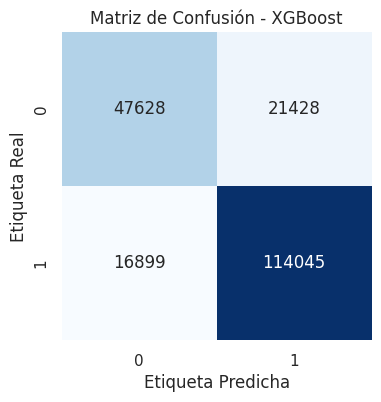

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_XGB)

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()



XGB Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     69056
           1       0.84      0.87      0.86    130944

    accuracy                           0.81    200000
   macro avg       0.79      0.78      0.78    200000
weighted avg       0.81      0.81      0.81    200000



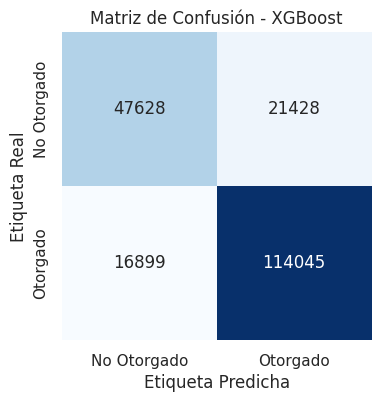

In [ ]:
# Obtener las etiquetas originales del LabelEncoder
labels = label_encoder_action_taken3.classes_

# Crear una nueva matriz de confusión con etiquetas originales
conf_matrix_labels = confusion_matrix(y_test, y_pred_XGB)

# Crear un dataframe de la matriz de confusión con etiquetas originales
conf_matrix_labels_df = pd.DataFrame(conf_matrix_labels, index=labels, columns=labels)
classification_rep_XGB = classification_report(y_test, y_pred_XGB)

# Imprimir métricas de rendimiento para XGBoost
print(f'XGB Classification Report:\n{classification_rep_XGB}')

# Visualizar la matriz de confusión con etiquetas originales
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_labels_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()


XGB Confusion Matrix:
             No Otorgado  Otorgado
No Otorgado        47628     21428
Otorgado           16899    114045
XGB Accuracy: 0.808365
XGB Confusion Matrix:
[[ 47628  21428]
 [ 16899 114045]]


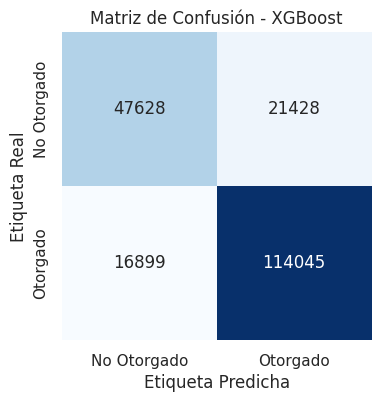

In [ ]:
# Obtener las etiquetas originales del LabelEncoder
labels_original = label_encoder_action_taken3.inverse_transform([0, 1])

# Crear una nueva matriz de confusión con etiquetas originales
conf_matrix_labels_df = pd.DataFrame(conf_matrix_labels, index=labels_original, columns=labels_original)

# Imprimir la matriz de confusión con etiquetas originales
print('XGB Confusion Matrix:')
print(conf_matrix_labels_df)

# Imprimir el informe de clasificación con etiquetas originales
classification_rep_XGB_original = classification_report(y_test, y_pred_XGB, target_names=labels_original)
print(f'XGB Accuracy: {accuracy_XGB}')
print(f'XGB Confusion Matrix:\n{conf_matrix_XGB}')
#print('XGB Classification Report:')
#print(classification_rep_XGB_original)

# Visualizar la matriz de confusión con etiquetas originales
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_labels_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()



# Gradient Boosting Clasifier

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Crear un imputador para reemplazar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')

# Imputar valores faltantes en el conjunto de entrenamiento y prueba
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Entrenar el modelo Gradient Boosting
GBT_model = GradientBoostingClassifier(random_state=123)
GBT_model.fit(X_train_imputed, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_GBT = GBT_model.predict(X_test_imputed)

# Evaluar el rendimiento del modelo
accuracy_GBT = accuracy_score(y_test, y_pred_GBT)
conf_matrix_GBT = confusion_matrix(y_test, y_pred_GBT)
classification_rep_GBT = classification_report(y_test, y_pred_GBT)

# Imprimir métricas de rendimiento para Gradient Boosting
print(f'GBT Accuracy: {accuracy_GBT}')
print(f'GBT Confusion Matrix:\n{conf_matrix_GBT}')
print(f'GBT Classification Report:\n{classification_rep_GBT}')


GBT Accuracy: 0.80135
GBT Confusion Matrix:
[[ 47127  21929]
 [ 17801 113143]]
GBT Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70     69056
           1       0.84      0.86      0.85    130944

    accuracy                           0.80    200000
   macro avg       0.78      0.77      0.78    200000
weighted avg       0.80      0.80      0.80    200000



# Random Forest

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Crear un imputador para reemplazar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')

# Imputar valores faltantes en el conjunto de entrenamiento y prueba
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Entrenar el modelo Random Forest
RF_model = RandomForestClassifier(n_estimators=100, random_state=0)
RF_model.fit(X_train_imputed, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_RF = RF_model.predict(X_test_imputed)

# Evaluar el rendimiento del modelo
accuracy_RF = accuracy_score(y_test, y_pred_RF)
conf_matrix_RF = confusion_matrix(y_test, y_pred_RF)
classification_rep_RF = classification_report(y_test, y_pred_RF)

# Imprimir métricas de rendimiento para Random Forest
print(f'Random Forest Accuracy: {accuracy_RF}')
print(f'Random Forest Confusion Matrix:\n{conf_matrix_RF}')
print(f'Random Forest Classification Report:\n{classification_rep_RF}')



Random Forest Accuracy: 0.782475
Random Forest Confusion Matrix:
[[ 42753  26303]
 [ 17202 113742]]
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.66     69056
           1       0.81      0.87      0.84    130944

    accuracy                           0.78    200000
   macro avg       0.76      0.74      0.75    200000
weighted avg       0.78      0.78      0.78    200000



# CatBoost

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Crear un conjunto de datos CatBoost para entrenamiento
train_pool_catboost = Pool(X_train, label=y_train)

# Crear un conjunto de datos CatBoost para prueba
test_pool_catboost = Pool(X_test, label=y_test)

# Configurar e instanciar el modelo CatBoost con hiperparámetros y métrica de evaluación
CatBoost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',  # Especificar la función de pérdida para clasificación multiclase
    eval_metric='Accuracy',  # Especificar la métrica de evaluación para clasificación multiclase
    random_state=0
    # Puedes ajustar más hiperparámetros según sea necesario
)

# Entrenar el modelo CatBoost
CatBoost_model.fit(train_pool_catboost, eval_set=test_pool_catboost)

# Hacer predicciones en el conjunto de prueba
y_pred_CatBoost = CatBoost_model.predict(X_test)

# Evaluar el rendimiento del modelo
Accuracy_CatBoost = accuracy_score(y_test, y_pred_CatBoost)
conf_matrix_CatBoost = confusion_matrix(y_test, y_pred_CatBoost)
classification_rep_CatBoost = classification_report(y_test, y_pred_CatBoost)

# Imprimir métricas de rendimiento para CatBoost
print(f'CatBoost Accuracy: {Accuracy_CatBoost}')
print(f'CatBoost Confusion Matrix:\n{conf_matrix_CatBoost}')
print(f'CatBoost Classification Report:\n{classification_rep_CatBoost}')






0:	learn: 0.7816912	test: 0.7826300	best: 0.7826300 (0)	total: 412ms	remaining: 40.8s
1:	learn: 0.7866888	test: 0.7872700	best: 0.7872700 (1)	total: 705ms	remaining: 34.6s
2:	learn: 0.7871075	test: 0.7885950	best: 0.7885950 (2)	total: 992ms	remaining: 32.1s
3:	learn: 0.7867713	test: 0.7881800	best: 0.7885950 (2)	total: 1.27s	remaining: 30.5s
4:	learn: 0.7907287	test: 0.7919000	best: 0.7919000 (4)	total: 1.55s	remaining: 29.5s
5:	learn: 0.7931238	test: 0.7938050	best: 0.7938050 (5)	total: 1.83s	remaining: 28.7s
6:	learn: 0.7939162	test: 0.7946350	best: 0.7946350 (6)	total: 2.12s	remaining: 28.2s
7:	learn: 0.7949900	test: 0.7958950	best: 0.7958950 (7)	total: 2.4s	remaining: 27.6s
8:	learn: 0.7956737	test: 0.7966800	best: 0.7966800 (8)	total: 2.71s	remaining: 27.4s
9:	learn: 0.7955000	test: 0.7963650	best: 0.7966800 (8)	total: 2.98s	remaining: 26.8s
10:	learn: 0.7961075	test: 0.7970050	best: 0.7970050 (10)	total: 3.26s	remaining: 26.4s
11:	learn: 0.7971037	test: 0.7977600	best: 0.7977600 

# Regresion Logistica

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Crear un imputador para reemplazar los valores faltantes con la media
imputer = SimpleImputer(strategy='mean')

# Imputar valores faltantes en el conjunto de entrenamiento y prueba
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Entrenar el modelo Logistic Regression (LR)
LR_model = LogisticRegression(random_state=1234, multi_class='multinomial', solver='newton-cg')
LR_model.fit(X_train_imputed, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_LR = LR_model.predict(X_test_imputed)

# Evaluar el rendimiento del modelo
accuracy_LR = accuracy_score(y_test, y_pred_LR)
conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)
classification_rep_LR = classification_report(y_test, y_pred_LR)

# Imprimir métricas de rendimiento para Logistic Regression (LR)
print(f'LR Accuracy: {accuracy_LR}')
print(f'LR Confusion Matrix:\n{conf_matrix_LR}')
print(f'LR Classification Report:\n{classification_rep_LR}')




/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


LR Accuracy: 0.65173
LR Confusion Matrix:
[[  1541  67515]
 [  2139 128805]]
LR Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.02      0.04     69056
           1       0.66      0.98      0.79    130944

    accuracy                           0.65    200000
   macro avg       0.54      0.50      0.41    200000
weighted avg       0.57      0.65      0.53    200000



#HISTGRADIENT BOOSTING CLASSIFIER

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # habilitar el soporte experimental para HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Instanciar y entrenar el modelo HistGradientBoostingClassifier
hgb_model = HistGradientBoostingClassifier()
hgb_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_hgb = hgb_model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy_hgb = accuracy_score(y_test, y_pred_hgb)
conf_matrix_hgb = confusion_matrix(y_test, y_pred_hgb)
classification_rep_hgb = classification_report(y_test, y_pred_hgb)

# Imprimir métricas de rendimiento para HistGradientBoostingClassifier
print(f'HistGradientBoostingClassifier Accuracy: {accuracy_hgb}')
print(f'HistGradientBoostingClassifier Confusion Matrix:\n{conf_matrix_hgb}')
print(f'HistGradientBoostingClassifier Classification Report:\n{classification_rep_hgb}')


/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


HistGradientBoostingClassifier Accuracy: 0.806935
HistGradientBoostingClassifier Confusion Matrix:
[[ 47615  21441]
 [ 17172 113772]]
HistGradientBoostingClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.69      0.71     69056
           1       0.84      0.87      0.85    130944

    accuracy                           0.81    200000
   macro avg       0.79      0.78      0.78    200000
weighted avg       0.80      0.81      0.81    200000



# LGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Instanciar y entrenar el modelo LGBMClassifier
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
classification_rep_lgbm = classification_report(y_test, y_pred_lgbm)

# Imprimir métricas de rendimiento para LGBMClassifier
print(f'LGBMClassifier Accuracy: {accuracy_lgbm}')
print(f'LGBMClassifier Confusion Matrix:\n{conf_matrix_lgbm}')
print(f'LGBMClassifier Classification Report:\n{classification_rep_lgbm}')



[LightGBM] [Info] Number of positive: 523370, number of negative: 276630
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 788
[LightGBM] [Info] Number of data points in the train set: 800000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654212 -> initscore=0.637608
[LightGBM] [Info] Start training from score 0.637608
LGBMClassifier Accuracy: 0.807315
LGBMClassifier Confusion Matrix:
[[ 47588  21468]
 [ 17069 113875]]
LGBMClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71     69056
           1       0.84      0.87      0.86    130944

    accuracy                           0.81    200000
   macro avg       0.79      0.78      0.78    200000
weighted avg       0.80      0.

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [ ]:
y_pred_proba = lgbm_model.predict_proba(X_test)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])


In [ ]:
roc_auc = auc(fpr, tpr)


<ipython-input-37-7a2f01134140>:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



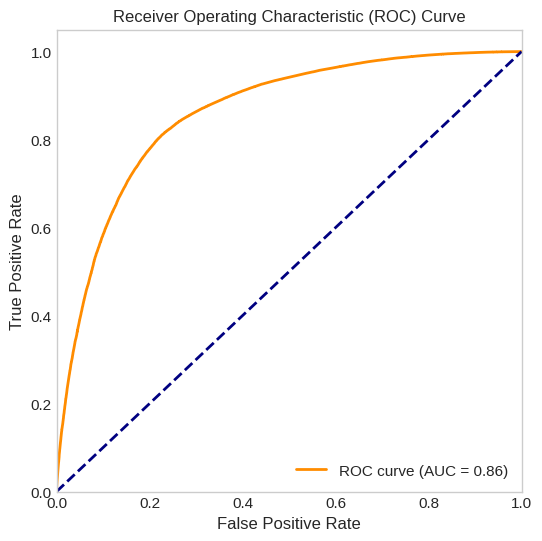

In [ ]:
plt.figure(figsize=(6, 6))
plt.style.use('seaborn-whitegrid')
plt.grid(None)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# COMPARACION DE MODELOS

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd

accuracy_list = [accuracy_XGB, accuracy_GBT, accuracy_RF,
                 accuracy_LR, Accuracy_CatBoost, accuracy_hgb , accuracy_lgbm]

model_list = ['XGBboost', 'Gradient Boosting', 'Random Forest',
               'Logistic Regresion', 'CatBoost_model', 'HistGradient Boost', 'LGBM Model']

df_accuracy = pd.DataFrame({'Model': model_list, 'Accuracy': accuracy_list})



In [ ]:
from tabulate import tabulate
from IPython.display import display, HTML

# Ordenar el DataFrame por Accuracy en orden descendente
df_accuracy_sorted = df_accuracy.sort_values(by='Accuracy', ascending=False)

# Imprimir la tabla en formato HTML
table_html = tabulate(df_accuracy_sorted, tablefmt='html', headers='keys', showindex=False)

# Visualizar la tabla en el notebook
display(HTML(table_html))


Model,Accuracy
XGBboost,0.808365
LGBM Model,0.807315
HistGradient Boost,0.806935
CatBoost_model,0.80336
Gradient Boosting,0.80135
Random Forest,0.782475
Logistic Regresion,0.65173


In [ ]:
pip install plotly

In [ ]:
import plotly.express as px

# Ordenar el DataFrame por Accuracy en orden descendente
df_accuracy_sorted = df_accuracy.sort_values(by='Accuracy', ascending=False)

# Crear un gráfico interactivo con Plotly
fig = px.bar(df_accuracy_sorted, x='Model', y='Accuracy', text='Accuracy',
             labels={'Accuracy': 'Accuracy (%)'}, title='Accuracy by Model')

# Ajustar el tamaño de la fuente
fig.update_layout(yaxis=dict(title=dict(font=dict(size=25))))  # Tamaño de la fuente en el eje y

# Ajustar el tamaño de la fuente en los números de las barras
fig.update_traces(textfont=dict(size=14))  # Tamaño de la fuente en los números de las barras

# Imprimir la tabla
table_html = tabulate(df_accuracy_sorted, tablefmt='html', headers='keys', showindex=False)

# Visualizar la tabla en el notebook
display(HTML(table_html))

# Visualizar el gráfico
fig.show()

Model,Accuracy
XGBboost,0.808365
LGBM Model,0.807315
HistGradient Boost,0.806935
CatBoost_model,0.80336
Gradient Boosting,0.80135
Random Forest,0.782475
Logistic Regresion,0.65173


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
from IPython.display import display, HTML

# Lista de modelos y sus reportes de clasificación
model_names = ['XGB_model', 'GBT_model', 'RF_model', 'LR_model', 'CatBoost_model', 'hgb_model', 'lgbm_model']
classification_reports = {}

# Calcular el reporte de clasificación para cada modelo
for model_name in model_names:
    model = globals()[model_name]
    y_pred = model.predict(X_test_imputed)
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_reports[model_name] = report

# Crear un DataFrame para almacenar las métricas
metrics_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score'])

# Iterar sobre los reportes de clasificación
for model_name, report in classification_reports.items():
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    metrics_df = metrics_df.append({'Model': model_name, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, ignore_index=True)

# Mostrar la tabla como HTML en el notebook
display(HTML(metrics_df.to_html(index=False)))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names

<ipython-input-28-ca45a049a917>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-28-ca45a049a917>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-28-ca45a049a917>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-28-ca45a049a917>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-28-ca45a049a917>:24: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future vers

Model,Precision,Recall,F1 Score
XGB_model,0.793716,0.794675,0.794151
GBT_model,0.799042,0.801350,0.799831
RF_model,0.777966,0.782475,0.778455
LR_model,0.574146,0.651730,0.530001
CatBoost_model,0.778608,0.782950,0.779239
hgb_model,0.798837,0.798950,0.798893
lgbm_model,0.798403,0.798555,0.798478
